<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_3_venice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 1.

In [ ]:
pip install umap-learn

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import  pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
from time import time as timer
import os
import tarfile

import tensorflow as tf

%matplotlib inline
import umap
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler

In [4]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

261349/261349 [==============================] - 0s 0us/step


In [5]:
from utils.routines import *

In [6]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)


def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)

    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)

    return features_scaled

**CLUSTERING Objective:**

Clustering techniques divide the set of data into group of points having common features. Each data point $p$ gets assigned a label $l_p \in \{1,..,K\}$ representing the group to which it belongs.

In this presentation the starting data points (data-cloud) are supposed to have $D$ features.

**General Caveat:**

Clustering techniques rely on a a-priori fixed notion of 'distance' between the points. This implies:

- The default distance is called `euclidean`: $d(x_p,x_{q})=\sqrt{\sum_{i} |x_{p,i}-x_{q,i}|^{2}}$. This distance is not invariant if we change units, if all features have difference units. If we want to use the the default euclidean distance when performing data analysis we should normalize variables beforehand.

- Other ad-hoc distances may be defined depending on the use-case scenario.

- Results of clustering must always be checked by experts of the field of interest. Clustering data therefore is an iterative process that requires trying out different type of techniques.

Note that if your data is labelled (e.g. each label is assigned to a class), the number of groups/clusters can be different than the number of classes. There is no reason that these numbers should be equal.

# 1. Non-linear dimensionality reduction

- Non-linear dimensionality reduction techniques can be used to map the original set of points with $D$ features into 2 features.

- PCA also offers such a mapping (take the first two relevant scores) but in general two components are not enough to conserve the variance. This happens because PCA limits itself to new features that are `linear combinations` of the old one

- Non-linear dimensionality reduction techniques do not pose themselves such a constraint and therefore can map data into very low dimensions (for example 2)

- If we have a map in 2D we can visualize clusters by eye

`t-Sne` and `UMAP` are the two most popular dimensionality reduction techniques. They differ in the type of information that is preserved before and after the mapping.

- `t-Sne` uses a `statistical description` of the environment of a sample point ;
- `UMAP` conserves the `connectivity` (topological) properties of the environment of a sample point ;

The projection on the low-dimensional space is optimized in order to match as much as possible the description of the local environment.

It is not the goal of this introduction to discuss the derivation of such approaches, which can be found in the references:

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

https://arxiv.org/pdf/1802.03426.pdf

Results between UMAP and t-Sne shoud be comparable.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=10, n_components=2, learning_rate=200,
#                   early_exaggeration=4.0,init='pca',
#                   n_iter=2000, random_state=2233212,
#                   metric='euclidean', verbose=100, n_jobs=1)

# tsne_mnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_mnist[:,0],tsne_mnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_mnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/mnist.png" width="100%"/> |
 |  -----:| -----:|

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


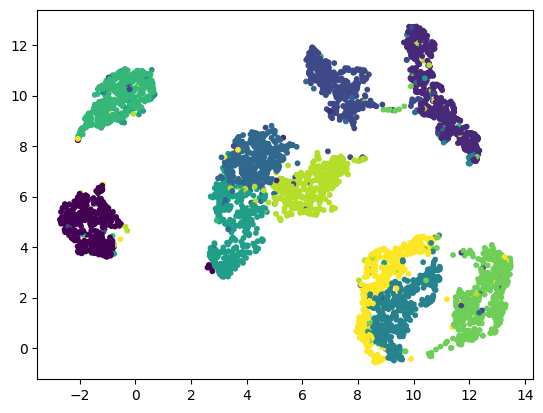

In [ ]:
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(data)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=labels, s=10)
plt.show()

We now thest the methodology on the AMES house dataset:

In [ ]:
data=house_prices_dataset_normed()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


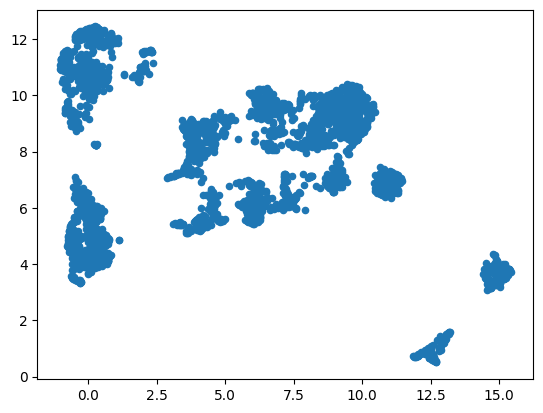

In [ ]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)
plt.show()

Note that in this case we do not have 'labels' with whom we can color the points so manual work is needed a posteriori to analyze what differentiates different clusters. We do not perform here further this analysis.

## 2. K-Means

Consider first that you know the number of groups over which you want to divide your data. For example $K=3$ or $K=10$ groups.

***-cluster centers***

K-means heavily relies on the concept of:

`cluster centers`. Each group gets assigned a cluster center, as a mean representative point. The centroids given by the expression:
$$\mathbf{c}_k=\frac{1}{N_k}\sum_{p \in S_k} \mathbf{x_p}$$

, $S_k$ is the subset of points assigned to the same group $k$ and $N_k$ is the number of points in $S_k$.

If the data cloud is made of images, it is the image containing at each pixel the mean value of all images of that group.

If the data cloud is made of questionnaires, it is the mean value assigned to an answer by all questionnaires belonging to that group.

If the data cloud is made of pressure sensors, it assigns to each sensors the mean of the pressure over all time spans belonging to that group, and so on...

$K-Means$ assign cluster center to a single group. All points whose closest cluster center belongs to class $K$, is assigned to group $K$ as well.


***-loss function***

The cluster centres are chosen in order to minimize the following loss function:

$$\sum_{k \in \text{classes}} \sum_{p \in S_k} d(\mathbf{x}_p,\mathbf{c}_{k})^2$$

where $S_k$ is the subset of points assigned to the same group $k$.

d is the metric function suited of the problem of interest. Here we use the Euclidean distance as a metric :

$$d(\mathbf{x}_p,\mathbf{c}_{k})=|\mathbf{x}_p-\mathbf{c}_{k}| \quad \quad $$


Such an algorithm finds local minima and may need to be started several times with different initializations.

**-vary the number of classes and validate the clustering**

*Silhouette score*: K-means clustering fixes the number of clusters a priori. Some technique must be chosen to score the different optimal clusterings for different $k$. One technique chooses the best *Silouhette score*. Intuitively, this evaluates the typical distance of points within a same clusters and compares it against the typical distance of points belonging to neighboring but different clusters ( https://en.wikipedia.org/wiki/Silhouette_(clustering) ).


### Sklearn: implementation and usage of K-means.

We start with a 2D example that can be visualized.

First we load the data-set.

In [7]:
points=km_load_th1()

Explore the data-set checking the dataset dimensionality.

In [8]:
print(points.shape)
print('We have ', points.shape[0], 'points with two features')

(120, 2)
We have  120 points with two features


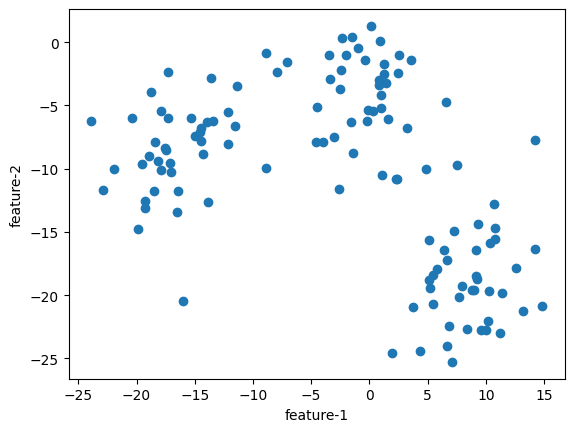

In [9]:
plt.plot(points[:,0],points[:,1],'o')
plt.xlabel('feature-1')
plt.ylabel('feature-2')
plt.show()

It looks visually that the data set has three clusters. We will cluster them using K-means. As usual, we create a KMeans object. Note that we do not need to initialize it with a data-set.

In [10]:
clusterer = KMeans(n_clusters=3, random_state=10, n_init=10)

A call to the fit method computes the cluster centers which can be plotted alongside the data-set. They are accessible from the cluster_centers_ attribute:

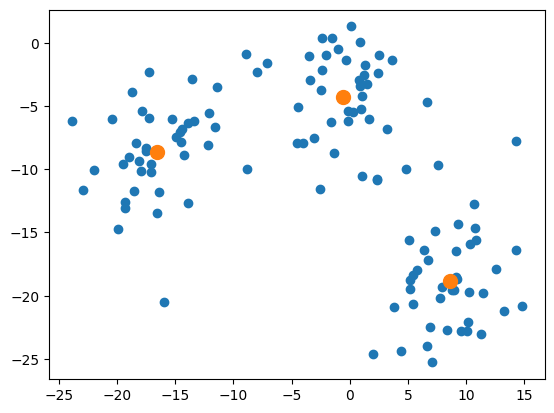

In [11]:
clusterer.fit(points)
plt.plot(points[:,0],points[:,1],'o')
plt.plot(clusterer.cluster_centers_[:,0],clusterer.cluster_centers_[:,1],'o',markersize=10)
plt.show()

In [12]:
clusterer.cluster_centers_[:,:]

array([[-16.59659661,  -8.6652939 ],
       [  8.5901409 , -18.82448838],
       [ -0.62089021,  -4.27748903]])

The predict method assigns a new point to the nearest cluster. We can use predict with the training dataset and color the data-set according to the cluster label.

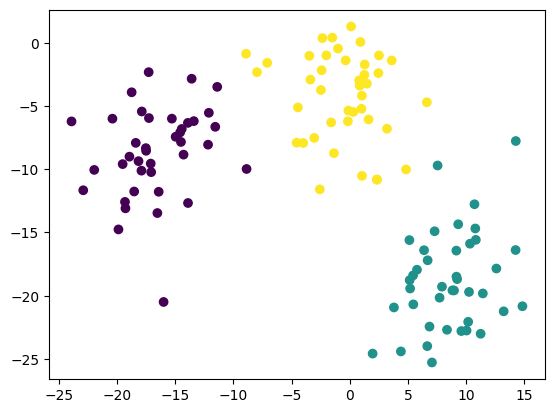

In [13]:
cluster_labels=clusterer.predict(points)
plt.scatter(points[:,0],points[:,1],c=cluster_labels)
plt.show()

Finally, we can try to vary the number of clusters and score them with the Silhouette score.

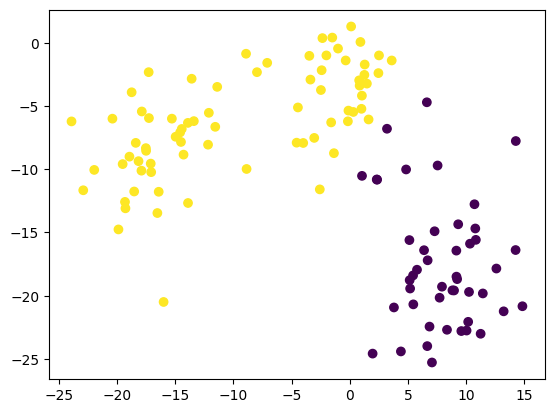

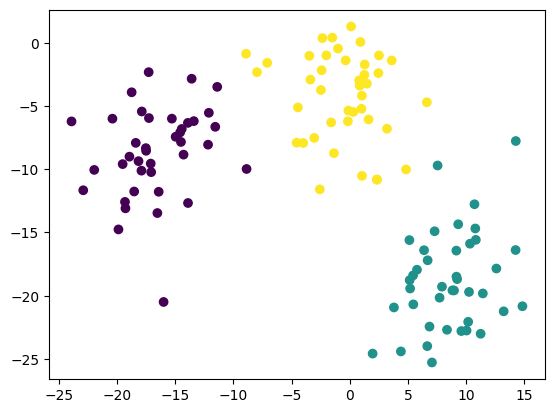

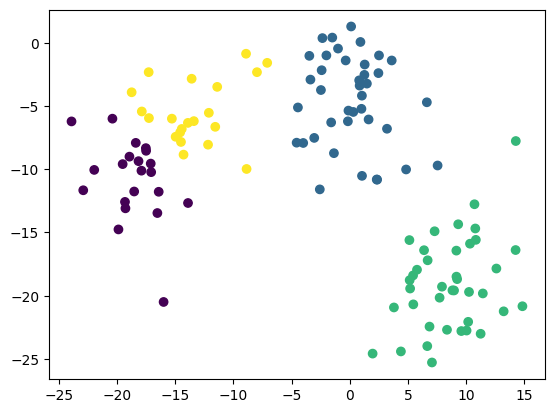

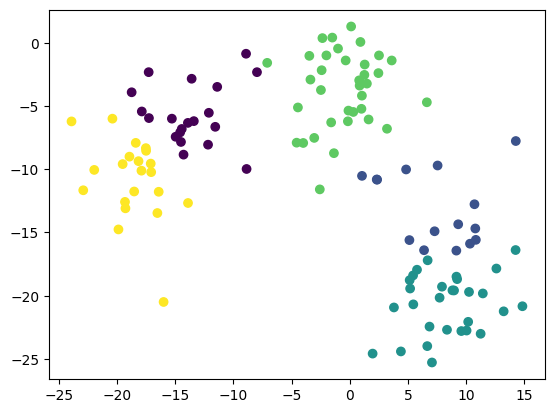

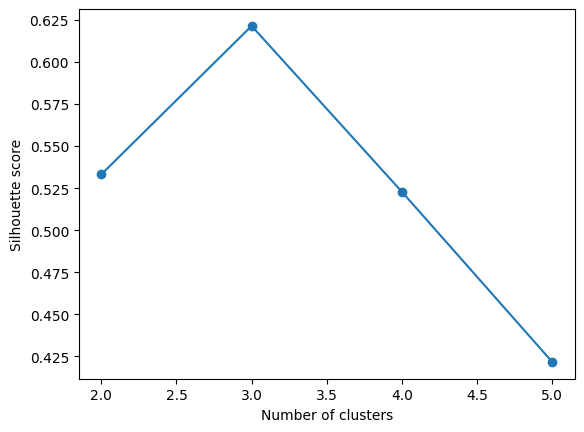

In [14]:
sil=[]

for iclust in range(2,6):
    clusterer = KMeans(n_clusters=iclust, random_state=10, n_init=10)
    cluster_labels = clusterer.fit_predict(points)
    score=silhouette_score(points,cluster_labels)
    sil.append(score)
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    plt.show()

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()

The same techniques can be used on high dimensional data-sets. We use here the famous MNIST dataset for integer digits, that we are downloading from tensorflow.

In [15]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

X=train_images[:5000,:].reshape(5000,-1)

4422102/4422102 [==============================] - 0s 0us/step


(5000, 784)


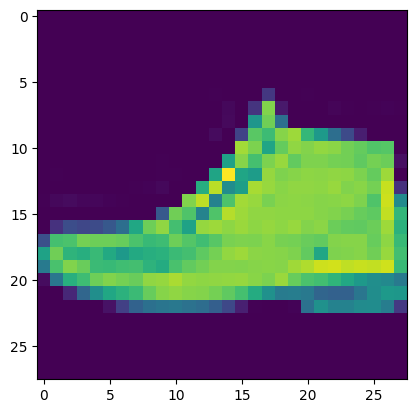

In [16]:
print(X.shape)
image=X[1232,:].reshape(28,28)
plt.imshow(image)

We can cluster the images exactly as we did for the 2d dataset.

In [17]:
clusterer = KMeans(n_clusters=10, random_state=10, n_init=10)
cluster_labels = clusterer.fit_predict(X)

We can plot the cluster centers (which are 2D figures!) to see if the clustering is learning correct patterns!

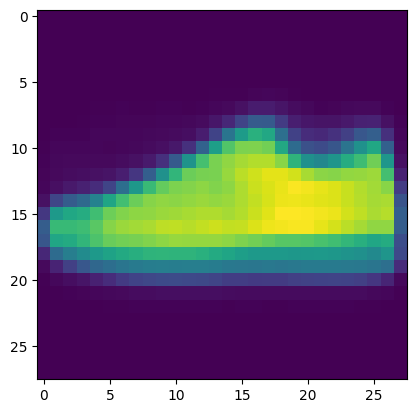

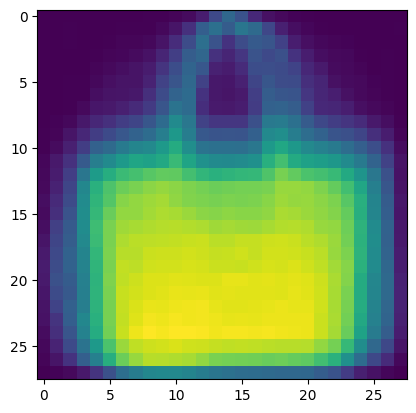

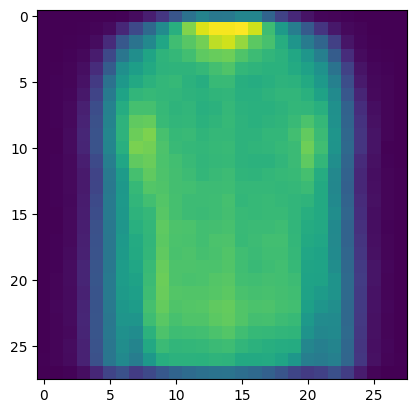

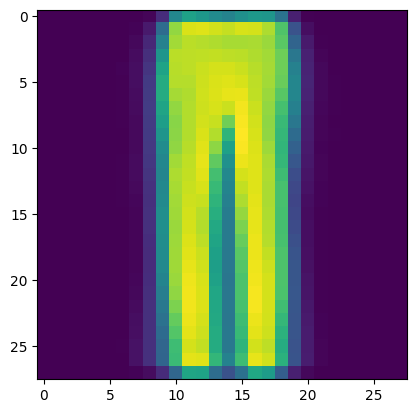

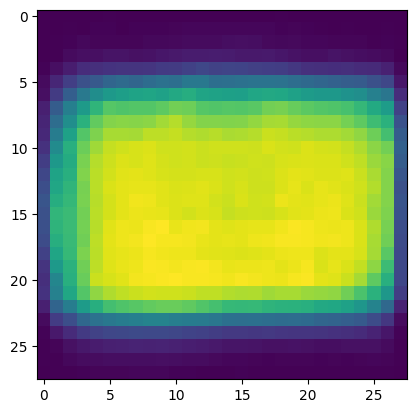

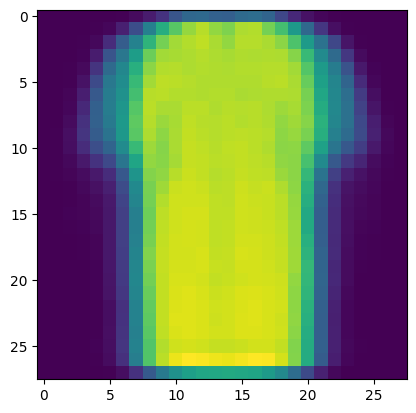

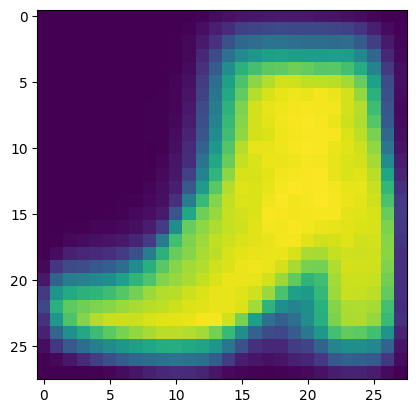

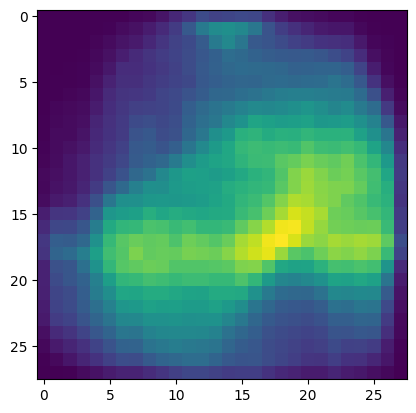

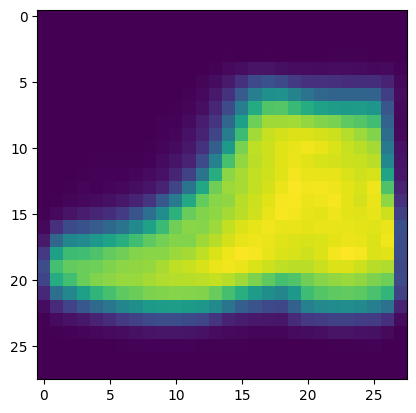

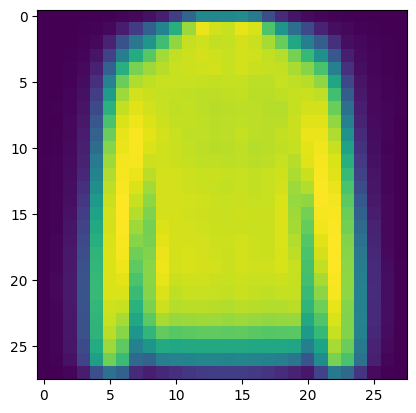

In [18]:
for iclust in range(10):
    plt.imshow(clusterer.cluster_centers_[iclust].reshape(28,28))
    plt.show()

You can see that the model is trying to assign one class to each group.

### EXERCISE 1: Discover the number of Gaussians

In [ ]:
### In this exercise you are given the dataset points, consisting of high-dimensional data. It was built taking random
# samples from a number k of multimensional gaussians. The data is therefore made of k clusters but, being
# very high dimensional, you cannot visualize it. Your task it to use K-means combined with the Silouhette
# score to find the number of k.

# 1. Load the data using the function points=load_ex1_data_clust() , check the dimensionality of the data.
points= ...
npoints, ndims = ...
print(npoints,ndims)

# 2. Fix the number of clusters k and define a KMeans clusterer object. Perform the fitting and compute the Silhouette score.
# Save the results on a list.
res= ...
for n_clusters in ... :
    clusterer = ...
    cluster_labels = ...
    score= ...
    res.append(score)

# 3. Plot the Silhouette scores as a function ok k? What is the number of clusters ?
plt.plot(...,...,'-o')

# 4. Optional. Check the result that you found via umap. Remember the syntax umap_model=umap.UMAP(random_state=xxx) to
# istantiate the umap model and than use fit_transform to compute the coordinate with the reduced dimensionality.

### EXERCISE 2: Predict the garment using K-Means and the Nearest Centroid algorithm

###### DESCRIPTION ###############

In this exercise you are asked to use the clustering performed by K-means to predict the good in the F-mnist dataset. We show here how clustering can be used as a preprocessing tool for a supervised task !

We will follow the pipeline to fit the model :

1- We perform K-means clustering using just the input data and fixing for the start the number of clusters to 10 ;

2- To each cluster, we will attach a label, finding the most represented good inside that cluster. Let's call that label
 assignment[c] for cluster c ;  

When using the model for prediction of a new image we will :

1- Find the cluster center nearest to the new image ;

2- Assign the new image to the good most represented in that cluster

This is called the Nearest Centroid algorithm and may be sometimes a good baseline.

In [ ]:
# Follow the following STEPS to solve the exercise

# STEP 1. Load the dataset and reshape it accordingly.
fmnist = ...
(train_images, train_labels), (test_images, test_labels) = ...
X_train=train_images[:5000,:].reshape(...,...)
y_train=train_labels[:5000]
X_test=test_images[:1000,:].reshape(...,...)
y_test=test_labels[:1000]


# STEP 2.
# Define the cluster KMeans object and fit the model on the training set.
clusterer = ...
clusterer.fit(...)

# STEP 3.
# Compute the cluster labels.
cluster_labels=...

# STEP 4.
# Compute the assignment list. assignment[i] will be the majority class of the i-cluster
# You can use, if you want,  the function most_common with arguments (k,y_train, cluster_labels)
# this compute the assignment list. Print the assignment list to explore its values.

def most_common(nclusters, supervised_labels, cluster_labels):
    """
    Args:
    - nclusters : the number of clusters
    - supervised_labels : for each garment, the labelling provided by the training data ( e.g. in y_train or y_test)
    - cluster_labels : for each garment, the cluster it was assigned by K-Means using the predict method of the Kmeans object

    Returns:
    - a list "assignment" of lengths nclusters, where assignment[i] is the majority class of the i-cluster
    """
    assignment=[]
    for icluster in range(nclusters):
        indices=list(supervised_labels[cluster_labels==icluster])
        try:
            chosen= max(set(indices), key=indices.count)
        except ValueError :
            print('Em')
            chosen=1
        assignment.append(chosen)
    return assignment
assignment=...

# STEP 5.
# Predict the cluster labels for the test set
cluster_labels_test=...

# STEP 6.
# using the cluster labels predicted in STEP 5 and the previously computed assignment[] list,
# predict what are according to your model the predicted goods for the test set, call them new_labels
# (The Python notation suggested is called list_comprehension)
new_labels = [assignment[...] for ... in ... ]

# STEP 7.
# Using  a call cm=metrics.confusion_matrix( y_test, new_labels ) you can print the confusion matrix on the test set,
# which
# provides information on the quality of the fit. Print the percentage of correctly classified examples.
# For example, you can divide the sum of the elements on the diagonal of cm (save it in denominator "den")
# and divide by the sum of all entries of cm (save it in numerator "num").
cm= ...
print(cm)
num=...
den=...
accuracy=num/den
print(num/den)

#  Perform again steps 2 / 7 increasing the number of clusters from 10 to 40 what happens to the performance ?
for iclust in ... :
    print(f'Test set with {iclust} clusters')
    # BEGIN OF YOUR CODE .
    # ...
    # END OF YOUR CODE
    print(assignment)
    print(accuracy)
    print(cm)
    return traj

## 3. Dendograms (hierarchical clustering)

**Objective:**

In hierarchical clustering we do not have only an optimal set of clusters, but for each different "length scale" we have a different set of clusters.

**Algorithm:**

- We start with a length scale $l=0$ at the beginning and consider all sample elements as different clusters.

- We increase than $l$ to values larger than zero. Let's call the minimum distance between pair of points $l_0$. As soon as we reach $l=l_0$, these elements are merged into a new cluster (greedy strategy).

To proceed further we need to define a distance between subsets $S_1,S_2$ of points. In the "single linkage" flavour we define:

$$d(S_1,S_2)=min_{a\in S_1, b\in S_2} d(a,b)$$

IMPORTANT: other linkage procedure exists. Check each time the documentation to see which is the default one if you did not specify it. Results may be dependent on the linkage criterion.

- This way we can proceed increasing $l>l_0$. As soon as we find two clusters with distance smaller than $l_1>l_0$, we merge them.

- We keep on increasing $l$ as far as one one cluster remains

The result of this clustering procedure can be summarized in a `dendrogram` . We demonstrate a dendogram using our 2D dataset but keep in mind that the right plot of the following visualization can be done also in higher dimensions, i.e. when you have more than 2 features, but the left plot is not straightforward (convince yourself why).

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy
from ipywidgets import interact
from scipy.cluster.hierarchy import fcluster

points=km_load_th1()
Z = hierarchy.linkage(points, 'single')
n_clusters=int(np.max(Z[:,[0,1]].flatten()))
print(n_clusters)

@interact
def plot(t=(0,7,0.1)):
    fig, axes=plt.subplots(1,2,figsize=(15,10), gridspec_kw={'width_ratios': [1, 2]})
    fl = fcluster(Z,t=t,criterion='distance')
    maps={}
    for clust in range(n_clusters):
        maps[clust]=(fl==clust)
    c=0
    for clust in range(n_clusters):
        if np.sum(maps[clust])>0:
            c+=1
    plt.figure(figsize=(19,5))
    d = hierarchy.dendrogram(Z,ax=axes[1], color_threshold=t)
    axes[1].axhline(t,linestyle='--',color='red')
    axes[1].set_ylabel('Cluster distance')
    axes[1].axes.get_xaxis().set_visible(False)
    axes[1].set_xlabel('Points')
    axes[1].set_title(f'Number clusters: {c}')
    axes[0].scatter(points[d['leaves'],0],points[d['leaves'],1], color=d['leaves_color_list'])
    plt.show()


237


interactive(children=(FloatSlider(value=3.0, description='t', max=7.0), Output()), _dom_classes=('widget-inter…

**Properties:**

If we fix a certain cutoff length $l_c$, the clusters identified $C_1,...,C_n$ at that length are such that :

1- The constintute a disjoint partition of the whole dataset, i.e. they are mutually non intersecting aand each point belongs to a cluster

2- The distance between two clusters $d(C_1,C_j)$ is larger than $l_c$ for each $i,j$.


## 4. Gaussian mixtures (soft clustering)

### Theory overview.

K-Means is a modelling procedure which is biased towards clusters of circular shape and therefore does not always work perfectly, as the following examples show:

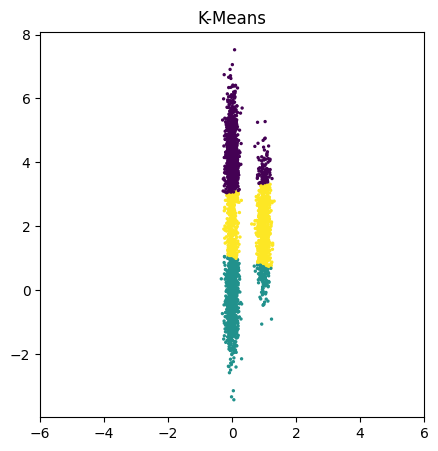

In [20]:
points=gm_load_th1()
clusterer = KMeans(n_clusters=3, random_state=10, n_init=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal')
plt.title('K-Means')
plt.xlim(-6,6)
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

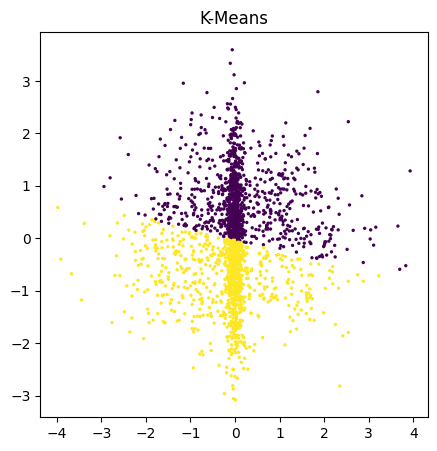

In [21]:
points=gm_load_th2()
clusterer = KMeans(n_clusters=2, random_state=10, n_init=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.title('K-Means')
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)

A Gaussian mixture model is able to fit these kinds of clusters. In a Gaussian mixture model, each point of the distribution is supposed to be a random point from a distribution given by a superposition of Gaussians:

$$f(\mathbf{x})=\sum_c \pi_c N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x})$$

Each Gaussian describes the shape of each group, that may be also non spherical or tilted.

This density has the following interpretation. Suppose each data point $\hat{X}$ results from the following 2-step procedure:

1- First choose a random number between $\{1,...,N_c\}$ using some prior probabilities $\{\pi_1,...\pi_{N_c}\}$. This random variable says to what group a the point belong.

2- Now we extract the features corresponding to that point $\hat{X}$ using the corresponding density $N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x})$.

The parameters $\{\pi_c,\mathbf{\mu_c},\mathbf{\Sigma_c}\}$ are fitted from the data using a minimization procedure (maximum likelihood via the EM algorithm) and $N_c$ is the chosen number of clusters.



**Output of a GM computation:**

Given the features of a new point we can reverse engineer the probability that this point was extracted one group or the other.

- *Cluster probabilities:* A gaussian mixtures model is an example of soft clustering, where each data point $p$ does not get assigned a unique cluster, but a distribution over clusters $f_p(c), c=1,...,N_c$.

- *AIC/BIC:* after each clustering two numbers are returned. These can be used to select the optimal number of Gaussians to be used, similar to the Silhouette score. ( AIC and BIC consider both the likelihood of the data given the parameters and the complexity of the model related to the number of Gaussians used ). The lowest AIC or BIC value is an indication of a good fit.

### Sklearn: implementation and usage of Gaussian mixtures

First of all, we see how the Gaussian model behaves on our original example:

2 1607.6200523512434 1638.282461521846


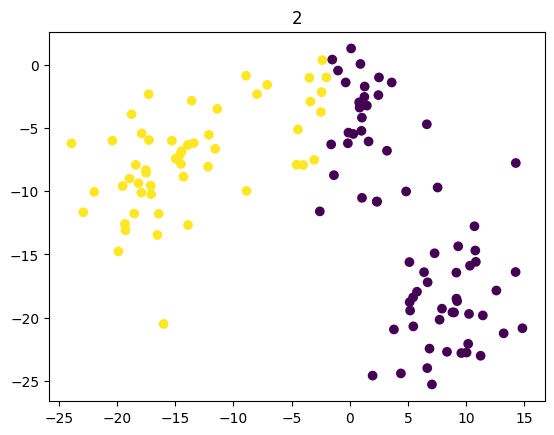

3 1550.4974051432473 1597.884764770542


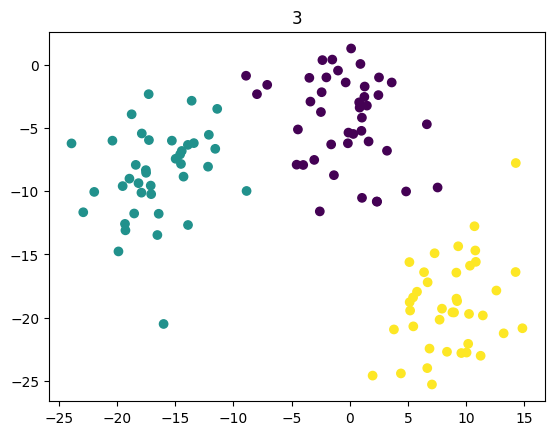

4 1555.3841898343276 1619.4964999183146


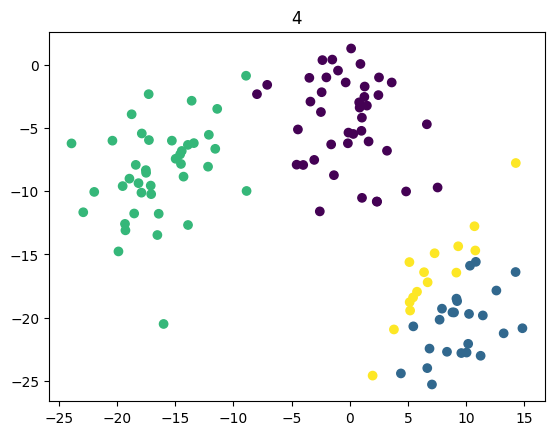

5 1552.1450684409297 1632.982328981609


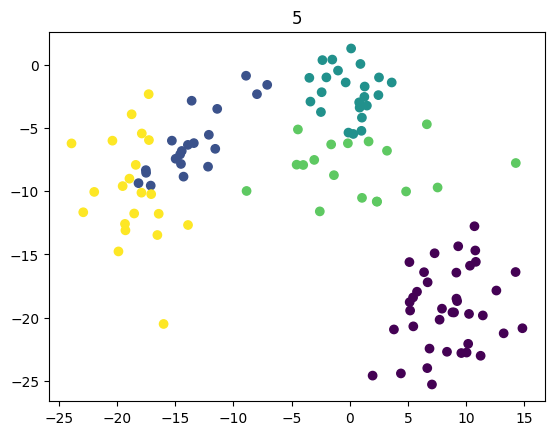

In [22]:
points=km_load_th1()

aic=[]
bic=[]
sil=[]

for i_comp in range(2,6):
    plt.figure()
    plt.title(str(i_comp))
    clf = GaussianMixture(n_components=i_comp, covariance_type='full')
    clf.fit(points)
    cluster_labels=clf.predict(points)
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    print(i_comp,clf.aic(points),clf.bic(points))
    score=silhouette_score(points,cluster_labels)
    aic.append(clf.aic(points))
    bic.append(clf.bic(points))
    sil.append(score)
    plt.show()

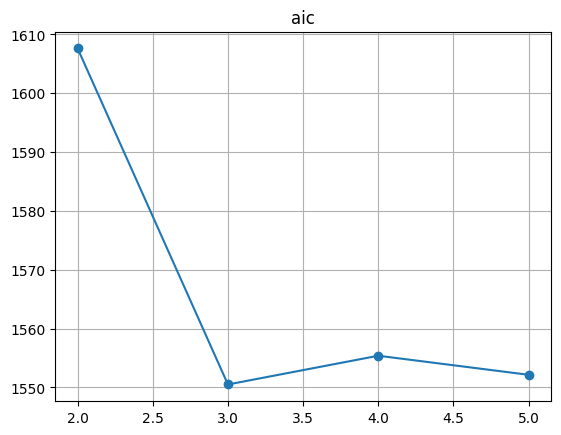

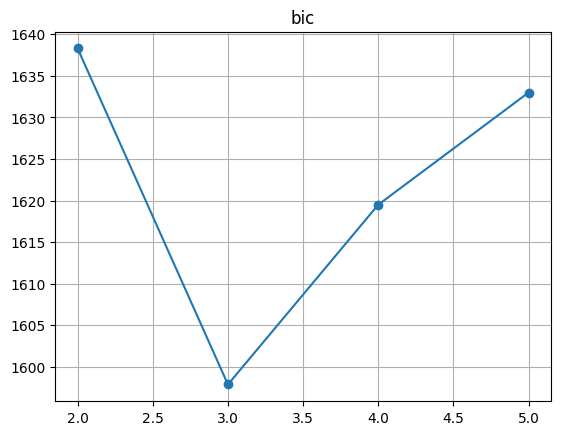

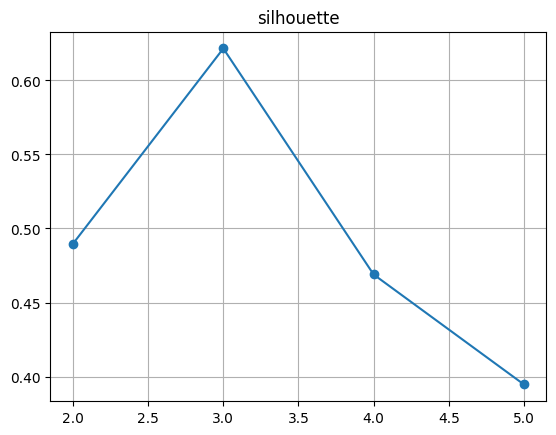

In [23]:
plt.plot(np.arange(2,6),aic,'-o')
plt.title('aic')
plt.grid()
plt.show()

plt.plot(np.arange(2,6),bic,'-o')
plt.title('bic')
plt.grid()
plt.show()

plt.plot(np.arange(2,6),sil,'-o')
plt.title('silhouette')
plt.grid()
plt.show()

So in this case we get a comparable result, and also the probabilistic tools agree with the Silhouette score ! Let's see how the Gaussian mixtures behave in the examples where K-means was failing.

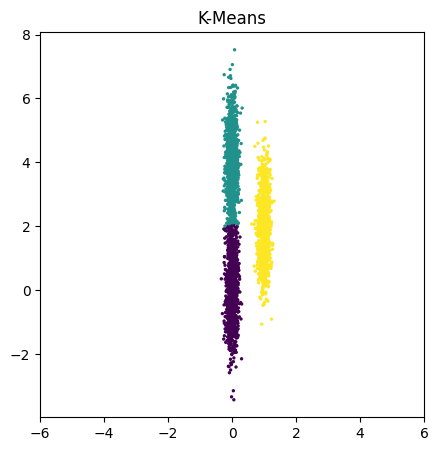

In [24]:
points=gm_load_th1()
clf = GaussianMixture(n_components=3, covariance_type='full')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal')
plt.title('K-Means')
plt.xlim(-6,6)
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

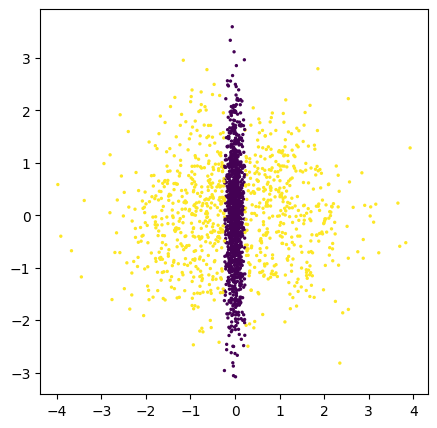

In [25]:
points=gm_load_th2()
clf = GaussianMixture(n_components=2, covariance_type='full')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

### EXERCISE 3: Find the cluster uncertainty with Gaussian mixtures

In [ ]:
#In this exercise you need to load the dataset used to present K-means ( def km_load_th1() ) or the one used to discuss
# the Gaussian mixtures model ( def gm_load_th1() ).
#As discussed, applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point,
#but also a probability distribution over the clusters.

#From this probability distribution, you can compute for each point the entropy of the corresponging
#distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction.
#Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.

# In detail you shoud:
# 1. Instantiate a GaussianMixture object with the number of clusters that you expect
# 2. fit the object on the dataset with the fit method

points=gm_load_th1()

plt.figure()
clf = GaussianMixture(..., covariance_type='full')
clf...(...)

# 3. compute the cluster probabilities using the method predict_proba. This will return a matrix of
# dimension npoints x nclusters (check that this is the case!)
# 4. use the entropy function ( from scipy.stats you need to import the entropy
# function ) to evaluate for each point the uncertainty of the
#prediction. Check here if in doubt: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

cluster_labels_prob=...

from ... import ...
entropies=[]
for point in range(len(...)):
    entropies.append(...)

# 5. Plot the points colored accordingly to their uncertanty.

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
plt.colorbar(sc)


# Final comments

We covered here the most basic clustering techniques, showcasing different behaviors. For real like projects, there are also other algorithms that could be taken into consideration, e.g. a popular algorithm is HDBSCAN:

- HDBSCAN : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

whose main characteristics is that it defines automatically an optimal number of clusters. HDBSCAN can fit clusters of also weirder shapes. It is often used in combination to a non-linear dimensionality reduction methodology like UMAP.

Ultimately, the best way to measure the quality of a cluster is by visual inspecting its elements and see if they make sense domain-wise.